<b>Hyperparameters</b>: 
<br><b>win_tol</b>: window tolerance within which if a method detected cp, count that as true changepoint detected
<br>win_tol=2
<br>For BOCD: <b>run_length_threshold</b> - the change in run_length that constitutes a changepoint, for example if run_length_threshold is set to 4, then if run length drops by 4 or more, then that constitutes a changepoint
<br>For gradient based: <b>gradient_threshold</b>: the threshold above which a change in gradient constitutes a changepoint.
<br>For MC_dropout: <b>mc_dropout_threshold</b>: the threshold above which a change in variance in any of the output dimensions constitutes a changepoint
<br>
<br> <b>If TP=FP=0, Precision=1 rather than 0 and if TP=FN=0, then Recall=1 rather than 0 
<br> zero division is taken as 1 and not 0 for Precision and Recall</b>
<br> example: true_cps = [3, 31, 250, 273], pred_cps = [30, 31, 249, 250, 272, 300]
<br> TP = 3, FP = 1, FN = 1, TN = 317-5 = 312
<br> true changepoint 3 could not be detected but the rest were detected within the window tolerance
<br> false changepoint 300 was detected
<br>
<br>Precision = TP/(TP+FP)
<br>Recall or A_cp = TP/(TP+FN)
<br>A_cp = Accuracy for detecting changepoints (minority class)
<br>Accuracy = (TP+TN)/(TP+TN+FP+FN)
<br>A_major or A_no_cp = TN/(TN+FP)
<br>A_major or A_no_cp = Accuracy for detecting points that are not changepoints (majority class)
<br>Balanced_Accuracy = 1/2*(A_cp+A_major)

In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from   matplotlib.colors import LogNorm
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score, auc
from sklearn import metrics

In [2]:
root_dir = "/home/users/richras/Ge2Net_Repo"
os.chdir(root_dir)

In [3]:
!./ini.sh

set environment variables
All done


In [8]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [9]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.decorators import timer
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred
import test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the model and use valid data to choose hyperpparams for the different cp methods

In [10]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_40_data_id_1_geo/') 
dataset_type='valid'

In [11]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
params.evalCp=True
params.evalBalancedGcd=True
params.evalExtraMainLosses=True
results, valid_dataset, _, modelStats=test.main(config, params)

 device used: cuda
Loading the datasets...
Finished '_geoConvertLatLong2nVec' in 0.0725 secs
Finished 'mapping_func' in 0.3736 secs
Finished 'pop_mapping' in 0.1612 secs
Finished 'pop_mapping' in 0.1617 secs
Finished 'transform_data' in 39.1073 secs
Finished '__init__' in 46.5149 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model BiRNN:60355
Parameter count for model logits_Block:2289
Total parameters:31810147
best val loss metrics : {'loss_main': 1019.345832937211, 'loss_aux': 2290.666619420077, 'l1_loss': 0.2355879116408647, 'mse': 0.055907890313560075, 'smooth_l1': 0.027914496680168585, 'weighted_loss': 0.2355879116408647}
at epoch : 158
train loss metrics: {'loss_main': 394.00804766059645, 'loss_aux': 1810.4329679636412, 'l1_loss': 0.08913686170153487, 'mse': 0.012651696828606474, 'smooth_l1': 0.006320104665269701, 'weighted_loss': 0.08913686170153487}
best val cp metrics : {'loss_cp': 0.3215919559710039, 'prMetrics': OrderedDict([('Precision', array(0.421

In [12]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [13]:
results.t_out.coord_main.shape

(3650, 317, 3)

In [14]:
results.t_accr, results.t_cp_accr

({'l1_loss': 0.22898937154293245,
  'loss_aux': 2531.0570640853894,
  'loss_main': 1136.7204027483688,
  'mse': 0.04857828424370571,
  'smooth_l1': 0.024259288463590056,
  'weighted_loss': 0.22898937154293245},
 {'loss_cp': 0.2603611757810812,
  'prMetrics': OrderedDict([('Precision', array(0.24304551)),
               ('Recall', array(0.37991705)),
               ('Accuracy', array(0.98759863)),
               ('A_major', array(0.99180658)),
               ('BalancedAccuracy', 0.6858618177653748)])})

In [15]:
@timer
def prMetricsByThresh(method_name, cp_pred_raw, cp_target, steps, minThresh, maxThresh, win_tol=2, byWindows=False):
    increment = (maxThresh - minThresh)/steps
    df=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
    for thresh in np.arange(minThresh, maxThresh + increment, increment):
        prMetrics, cp_pred = reportChangePointMetrics(method_name, cp_pred_raw, cp_target, thresh, win_tol)
        if byWindows: 
            prMetrics={}
            prMetrics['Precision']=precision_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Recall']=recall_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['BalancedAccuracy']=balanced_accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Accuracy']=accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['A_major']=(2*prMetrics['BalancedAccuracy'])-prMetrics['Recall']
        prMetrics['thresh']=thresh
        prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
        df=df.append(prMetrics, ignore_index=True)
    return df

# neural network, choose the threshold for logits

In [35]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        torch.tensor(valid_dataset.data['cps']).unsqueeze(2).float(), 20, 0, 0.53)
df_nn.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 25.8573 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007063753101544225,1.0,0.033319216974201635,0.026625347121599384,0.513313,0.000000,0.014028
1,0.00916268080447185,0.9991202714590927,0.25698370856920616,0.2518447157888874,0.625482,0.026500,0.018159
2,0.01270678571716634,0.9899459595324871,0.47097532518041574,0.4673816653656406,0.728664,0.053000,0.025092
3,0.014968756770644595,0.9811486741234133,0.5558567045503652,0.5529117312523878,0.767030,0.079500,0.029488
4,0.016975766812474848,0.9700892296091492,0.613477377814269,0.6110079862987591,0.790549,0.106000,0.033368
5,0.018444769476585618,0.960412215659168,0.6482511559569595,0.6460895680332227,0.803251,0.132500,0.036194
6,0.020860539186215266,0.9375392735955762,0.6969448165593535,0.6952787981477565,0.816409,0.159000,0.040813
7,0.030456429349162307,0.8718109840392108,0.8082615271595869,0.8078214731096612,0.839816,0.185500,0.058857
8,0.038482833380929345,0.8298353650873445,0.8562430318482347,0.8564258941617432,0.843131,0.212000,0.073555
9,0.04174495600679012,0.8097272841523188,0.8708672918197139,0.8712906614173092,0.840509,0.238500,0.079397


In [17]:
nnThresh=0.455

# gradient method, choose the threshold for gradient difference in predictions

In [18]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        torch.tensor(valid_dataset.data['cps']).unsqueeze(2).float(), 20, 0,1)
df_grad.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 7.1828 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007086602251646075,1.0,0.03645823430275269,0.029786100863898744,0.514893,0.000000,0.014073
1,0.2172566371681416,0.7404800804323237,0.9798686314333866,0.9815262994379045,0.861003,0.050000,0.335947
2,0.4300684874989686,0.6550207364584643,0.991658096020051,0.9939891723298289,0.824505,0.100000,0.519227
3,0.5962772785622593,0.5837627246449667,0.9944194287195887,0.9972630587776621,0.790513,0.150000,0.589954
4,0.7073337902673064,0.5187884881236647,0.9952145542543538,0.9985136102996015,0.758651,0.200000,0.598564
5,0.7805609077285378,0.4582128943068996,0.9953882718983622,0.9991079921294447,0.728660,0.250000,0.577447
6,0.830808729139923,0.40668593691089605,0.9953502441553952,0.9994265042081015,0.703056,0.300000,0.546068
7,0.8612612612612612,0.3604373507603368,0.9952024545179552,0.9995979437695643,0.680018,0.350000,0.508195
8,0.8966971187631764,0.32072389091366094,0.9950745430188842,0.9997441460351774,0.660234,0.400000,0.472461
9,0.9171428571428571,0.2823928616312681,0.9948895899053628,0.999823338929051,0.641108,0.450000,0.431825


In [19]:
gradThresh=0.1

# mc dropout variance, choose the threshold for difference in variance

In [20]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        torch.tensor(valid_dataset.data['cps']).unsqueeze(2).float(), 20, 0,0.5)
df_var.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 6.3812 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007063753101544225,1.0,0.033319216974201635,0.026625347121599384,0.513313,0.000000,0.014028
1,0.04877964758771552,0.355913032549956,0.9478414934531784,0.9519403564376425,0.653927,0.025000,0.085800
2,0.07315700619020822,0.16337815759708432,0.9800120997363986,0.9856669564604431,0.574523,0.050000,0.101061
3,0.08110056470022828,0.08483096644463994,0.9870964953977789,0.993344315908286,0.539088,0.075000,0.082924
4,0.09424083769633508,0.05655397762975996,0.9897739942094118,0.9962361619120471,0.526395,0.100000,0.070688
5,0.10790634543603665,0.0399648108583637,0.9911257076185126,0.9977121085934733,0.518838,0.125000,0.058327
6,0.12221144519883609,0.031670227472665576,0.9917765005833802,0.9984248446383365,0.515048,0.150000,0.050304
7,0.13246753246753246,0.02563780319215785,0.9921446782766519,0.9988373438877445,0.512238,0.175000,0.042961
8,0.14322033898305084,0.02123916048762096,0.9923953156734799,0.9991201756515791,0.510180,0.200000,0.036992
9,0.16889428918590524,0.017468895312303633,0.9926520029385074,0.9994047479185758,0.508437,0.225000,0.031663


In [21]:
varThresh=0.025

# BOCD, Compute the run lengths and changepoints by using a multivariate Gaussian (with independent three dimensions of predictions) to model the prediction sequence

In [22]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, _, predictive, e_mean = model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 190.1657 secs


In [28]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        torch.tensor(valid_dataset.data['cps']).unsqueeze(2).float(), 20,1,10)
df_bocd.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 18.4928 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.7226874003189793,0.45557370868417746,0.9950538006136295,0.9987894800507879,0.727182,1.000000,0.558853
1,0.7226874003189793,0.45557370868417746,0.9950538006136295,0.9987894800507879,0.727182,1.450000,0.558853
2,0.7226874003189793,0.45557370868417746,0.9950538006136295,0.9987894800507879,0.727182,1.900000,0.558853
3,0.6012681835136143,0.6077667462611537,0.9945309191478329,0.9972091031796382,0.802488,2.350000,0.604500
4,0.6012681835136143,0.6077667462611537,0.9945309191478329,0.9972091031796382,0.802488,2.800000,0.604500
5,0.5228624154193151,0.6409450798039462,0.9935084914221511,0.9959498491418884,0.818447,3.250000,0.575913
6,0.5228624154193151,0.6409450798039462,0.9935084914221511,0.9959498491418884,0.818447,3.700000,0.575913
7,0.4689748201438849,0.655397762975996,0.9925266842400934,0.9948611644140205,0.825129,4.150000,0.546732
8,0.4689748201438849,0.655397762975996,0.9925266842400934,0.9948611644140205,0.825129,4.600000,0.546732
9,0.4321443214432144,0.662309915797411,0.9916926666954755,0.9939735078013703,0.828142,5.050000,0.523025


In [24]:
bocdThresh=2.0

# Summary Table with chosen thresholds

In [25]:
pd.options.display.float_format='{:,.4f}'.format
df_summary=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
cpThresh=[nnThresh, gradThresh, varThresh, bocdThresh]
cp_target=valid_dataset.data['cps']
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, cp_target, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary=df_summary.append(prMetrics, ignore_index=True)
df_summary

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.2470290771175727,0.3683549076285032,0.9879348342768247,0.9922251723750819,0.6803,0.4550,0.2957,neural_network
1,0.4300684874989686,0.6550207364584643,0.991658096020051,0.9939891723298289,0.8245,0.1000,0.5192,gradient
2,0.04877964758771552,0.355913032549956,0.9478414934531784,0.9519403564376425,0.6539,0.0250,0.0858,mc_dropout
3,0.6012681835136143,0.6077667462611537,0.9945309191478329,0.9972091031796382,0.8025,2.0000,0.6045,BOCD


plot of Precision/Recall

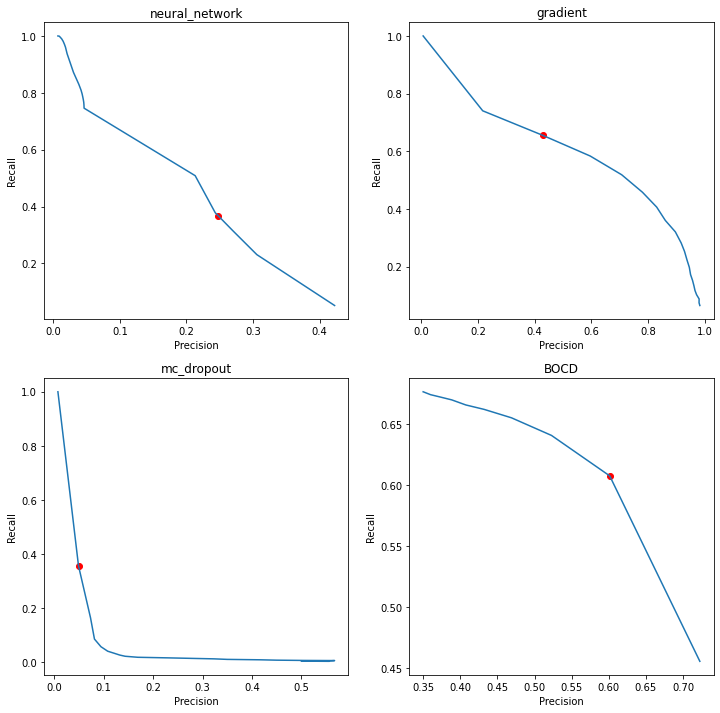

In [36]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    ax[row,col].plot(df['Precision'], df['Recall'])
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
    df_row=df_summary[df_summary.Name==name]
    ax[row,col].scatter(df_row['Precision'], df_row['Recall'], color='r')
plt.show()

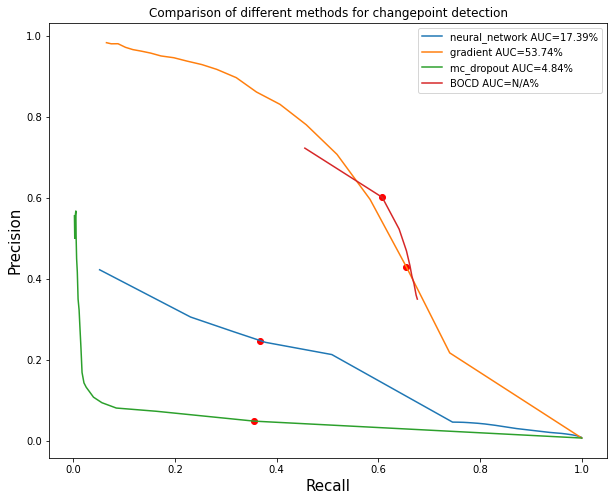

In [37]:
fig, ax = plt.subplots(figsize=[10,8])

for df, name in zip([df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    aucScore = "N/A"
    if name!="BOCD":
        aucScore = format(auc(df['Recall'], df['Precision'])*100, ".2f")
    plt.plot(df['Recall'], df['Precision'], label=str(name) + " AUC="+ str(aucScore)+"%")
    plt.ylabel('Precision', fontsize=15)
    plt.xlabel('Recall', fontsize=15)
    plt.title("Comparison of different methods for changepoint detection")
    df_row=df_summary[df_summary.Name==name]
    plt.scatter(df_row['Recall'], df_row['Precision'], color='r')
    plt.legend(loc="best")
plt.show()

# Qualitative by looking at anecdotes/samples

In [40]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
cp_target=valid_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
pred_cps = {}
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    _, pred_cps[name]= reportChangePointMetrics(name, pred_raw, cp_target, thresh)

true_cps=cp_target
pred_cps={k:v.detach().cpu().numpy() for k,v in pred_cps.items()}

In [41]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, y_var, popNames):
    fig, ax = plt.subplots(8,1,figsize=[18,30])
    ax[0].plot(y_pred)
    ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[0].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
        ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=10)
    ax[1].plot(pred_cps[cpMethod.gradient.name])
    ax[2].plot(y_var)
    ax[3].plot(pred_cps[cpMethod.mc_dropout.name])
    ax[4].plot(pred_cps[cpMethod.neural_network.name])
    ax[5].plot(np.arange(T+1), bocp_rl)
    ax[6].plot(pred_cps[cpMethod.BOCD.name])
    ax[7].plot(true_cps)
    
    ax[0].set_title("n_vectors")
    ax[1].set_title("Simple gradient(post_process)")
    ax[2].set_title("Mc dropout variance")
    ax[3].set_title("Mc dropout")
    ax[4].set_title("Neural Network predicted cp")
    ax[5].set_title("BOCD (post process) run_length")
    ax[6].set_title("BOCD (post process) cp")
    ax[7].set_title("True Cps")
    plt.show()

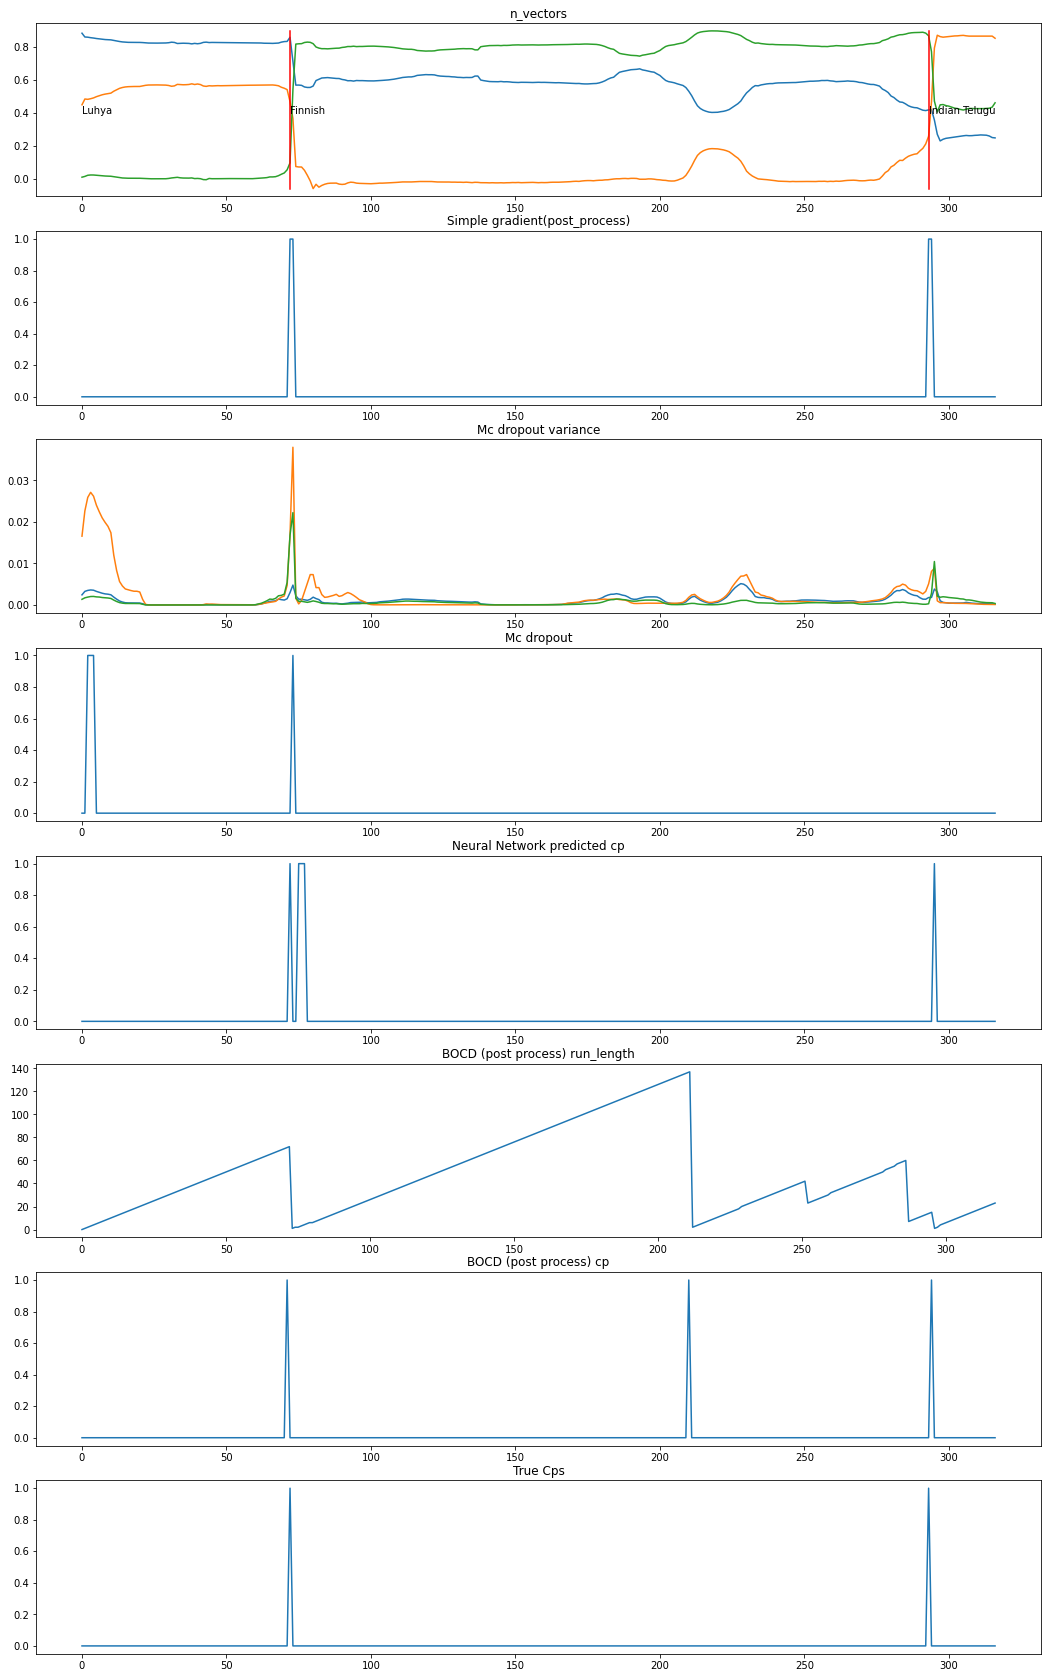

In [43]:
index = 2000
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

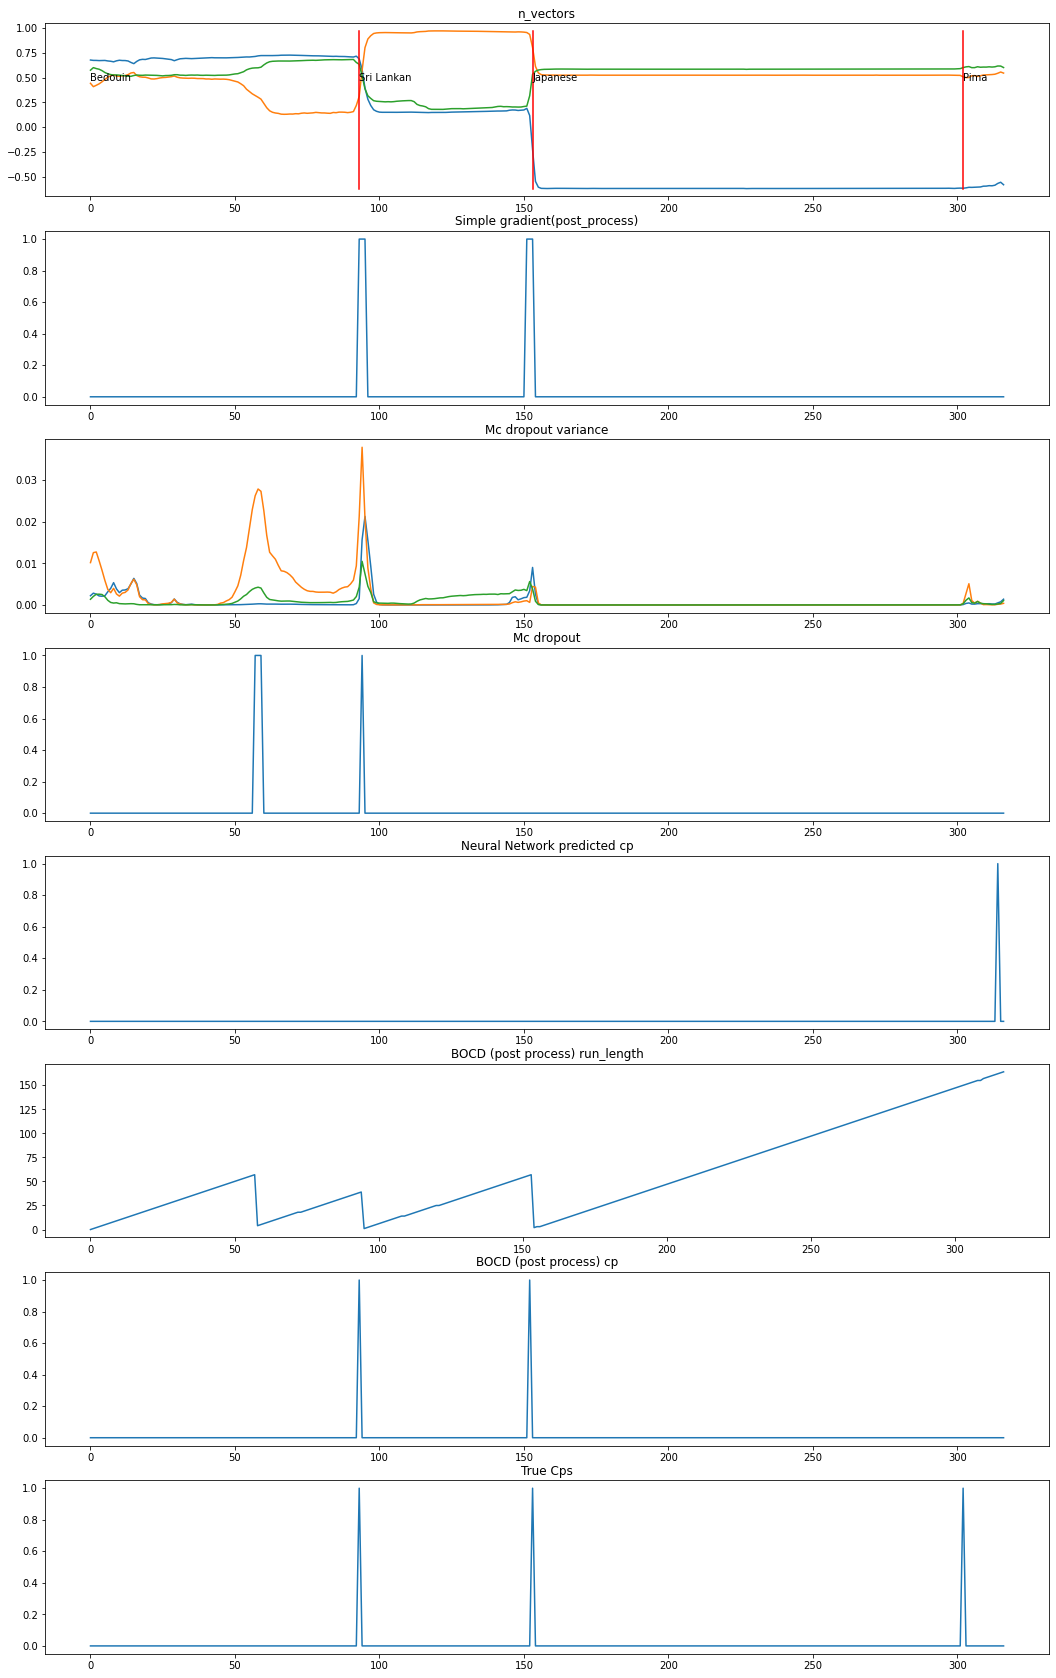

In [45]:
index = 2620
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

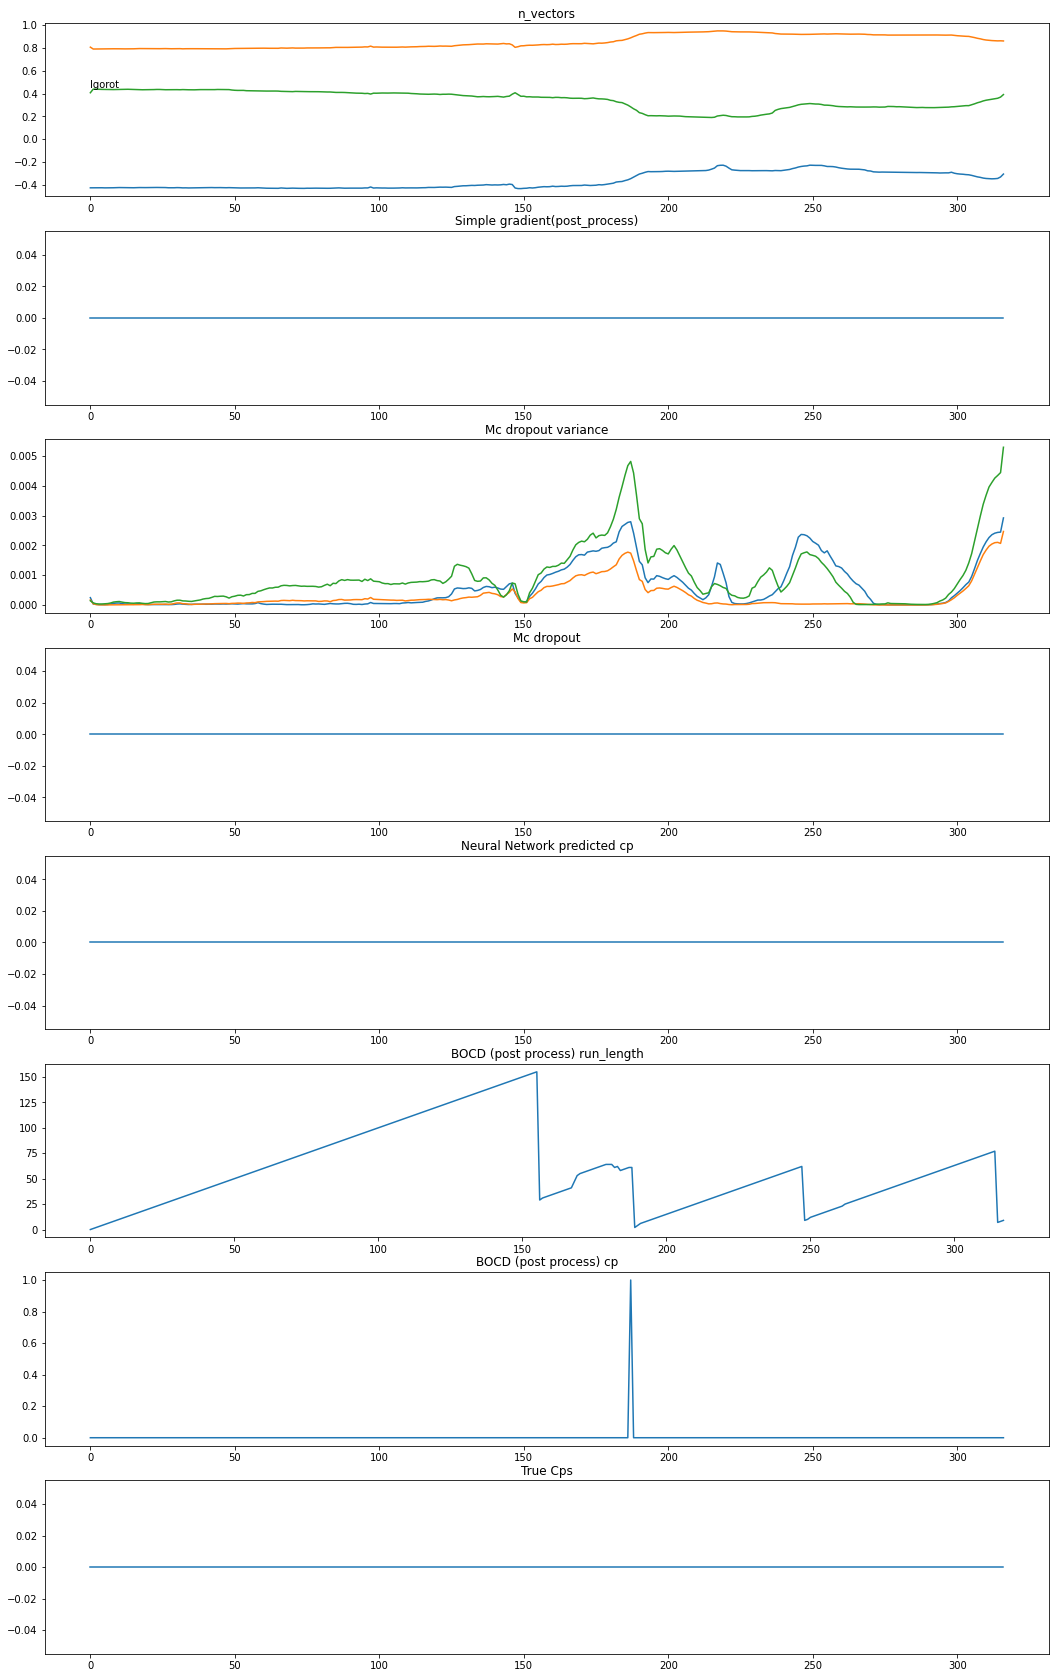

In [46]:
index = 1200
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

# evaluate on a subset of samples that have at least 1 changepoint 


In [49]:
subset_idx=np.unique(np.nonzero(valid_dataset.data['cps'])[0])

In [51]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'][..., np.newaxis][subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.31782693558880937,0.3683549076285032,0.9835785117491199,0.9907648403334699,0.6796,0.4550,0.3412,neural_network
1,0.5155291790306628,0.6550207364584643,0.9889096549702681,0.9928097580596623,0.8239,0.1000,0.5770,gradient
2,0.0704810731440233,0.355913032549956,0.9383682696856164,0.9451718362128065,0.6505,0.0250,0.1177,mc_dropout
3,0.7020905923344948,0.6077667462611537,0.992493738736255,0.9969876732418185,0.8024,2.0000,0.6515,BOCD


# compute metrics by placing win_tol=0

In [54]:
df_zero_tol=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=valid_dataset.data['cps'][..., np.newaxis]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_zero_tol=df_zero_tol.append(prMetrics, ignore_index=True)
df_zero_tol

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.09994046733144814,0.1687822043483725,0.9838304308370425,0.9894743071274474,0.5791,0.4550,0.1255,neural_network
1,0.23324851569126379,0.5529722257132085,0.9844250464543451,0.9874126811319884,0.7702,0.1000,0.3281,gradient
2,0.024339542344583756,0.1868794771898957,0.9428918369992654,0.948126914009571,0.5675,0.0250,0.0431,mc_dropout
3,0.2715758102570471,0.2748523312806334,0.9899433905189923,0.9948951042256806,0.6349,2.0000,0.2732,BOCD


# evaluate to make sure matches with scikit learn (subset with samples that have cp, and win_tol=0 for evaluation

In [56]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'][..., np.newaxis][subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.12440944881889764,0.1687822043483725,0.976687494014435,0.9861245065700138,0.5775,0.4550,0.1432,neural_network
1,0.26105013349154554,0.5529722257132085,0.9767658505016267,0.9817161160949558,0.7673,0.1000,0.3547,gradient
2,0.03440696006293674,0.1868794771898957,0.9300581289051277,0.9387390799485027,0.5628,0.0250,0.0581,mc_dropout
3,0.3170484198318353,0.2748523312806334,0.9847915862545309,0.9930842732174497,0.6340,2.0000,0.2944,BOCD


# evaluate by Windows

In [58]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        valid_dataset.data['cps'][..., np.newaxis], 20, 0.4, 0.5, byWindows=True)
df_nn.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 107.1862 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.025598,0.432198,0.882958,0.886079,0.659138,0.400000,0.048334
1,0.025464,0.428051,0.883410,0.886564,0.657307,0.405000,0.048069
2,0.025412,0.425412,0.883850,0.887025,0.656218,0.410000,0.047959
3,0.086836,0.304009,0.973228,0.977863,0.640936,0.415000,0.135087
4,0.092770,0.284278,0.975960,0.980749,0.632514,0.420000,0.139889
5,0.097702,0.260777,0.978354,0.983323,0.622050,0.425000,0.142148
6,0.095730,0.203720,0.981290,0.986675,0.595197,0.430000,0.130253
7,0.096822,0.196808,0.981851,0.987287,0.592048,0.435000,0.129792
8,0.097501,0.189267,0.982377,0.987869,0.588568,0.440000,0.128701
9,0.098761,0.183361,0.982877,0.988413,0.585887,0.445000,0.128377


In [59]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        valid_dataset.data['cps'][..., np.newaxis], 20, 0,1, byWindows=True)
df_grad.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 114.9151 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006899,1.000000,0.010032,0.003176,0.501588,0.000000,0.013703
1,0.135516,0.665829,0.968492,0.970588,0.818208,0.050000,0.225198
2,0.233249,0.552972,0.984425,0.987413,0.770192,0.100000,0.328101
3,0.312390,0.468644,0.989252,0.992857,0.730750,0.150000,0.374887
4,0.377490,0.407189,0.991305,0.995350,0.701269,0.200000,0.391778
5,0.425844,0.350383,0.992284,0.996729,0.673556,0.250000,0.384446
6,0.467107,0.302501,0.992830,0.997610,0.650056,0.300000,0.367201
7,0.500595,0.264547,0.993127,0.998172,0.631360,0.350000,0.346160
8,0.540046,0.233882,0.993362,0.998621,0.616251,0.400000,0.326405
9,0.564238,0.201458,0.993438,0.998923,0.600190,0.450000,0.296907


In [60]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        valid_dataset.data['cps'][..., np.newaxis], 20, 0,0.5, byWindows=True)
df_var.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 113.9861 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006877,1.000000,0.006877,0.000000,0.500000,0.000000,0.013660
1,0.024340,0.186879,0.942892,0.948127,0.567503,0.025000,0.043070
2,0.031843,0.075280,0.977901,0.984151,0.529715,0.050000,0.044755
3,0.036483,0.040468,0.986052,0.992599,0.516533,0.075000,0.038372
4,0.042176,0.026895,0.989108,0.995771,0.511333,0.100000,0.032845
5,0.041971,0.016589,0.990633,0.997378,0.506984,0.125000,0.023779
6,0.044898,0.012442,0.991388,0.998167,0.505305,0.150000,0.019484
7,0.047359,0.009803,0.991834,0.998635,0.504219,0.175000,0.016243
8,0.050473,0.008043,0.992138,0.998952,0.503498,0.200000,0.013875
9,0.060606,0.006786,0.992446,0.999272,0.503029,0.225000,0.012206


In [61]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        valid_dataset.data['cps'][..., np.newaxis], 20,1,11, byWindows=True)
df_bocd.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 127.4744 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.340744,0.211889,0.991761,0.997161,0.604525,1.000000,0.261294
1,0.340744,0.211889,0.991761,0.997161,0.604525,1.500000,0.261294
2,0.271576,0.274852,0.989943,0.994895,0.634874,2.000000,0.273204
3,0.271576,0.274852,0.989943,0.994895,0.634874,2.500000,0.273204
4,0.228292,0.281513,0.988515,0.993410,0.637462,3.000000,0.252124
5,0.228292,0.281513,0.988515,0.993410,0.637462,3.500000,0.252124
6,0.201427,0.283775,0.987338,0.992210,0.637992,4.000000,0.235613
7,0.201427,0.283775,0.987338,0.992210,0.637992,4.500000,0.235613
8,0.184914,0.285912,0.986422,0.991273,0.638592,5.000000,0.224580
9,0.184914,0.285912,0.986422,0.991273,0.638592,5.500000,0.224580


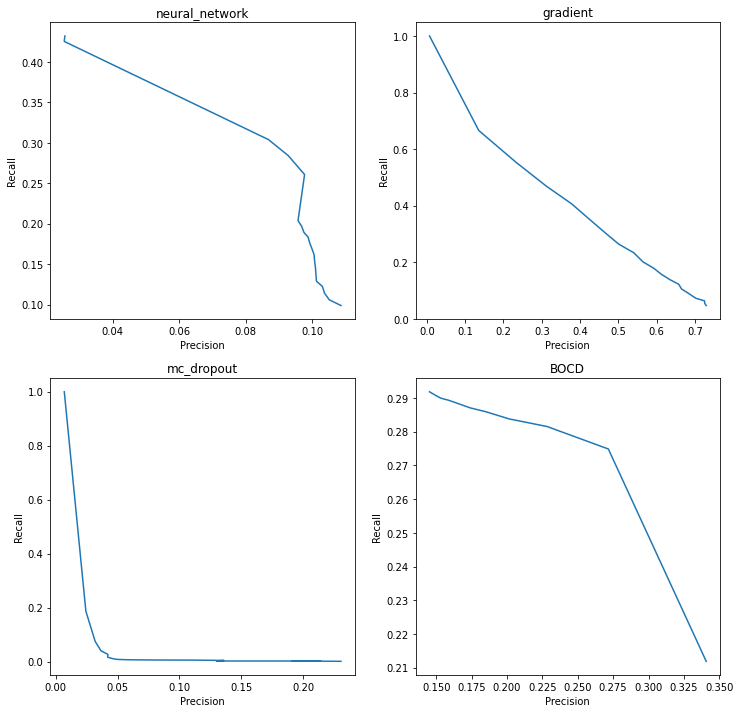

In [62]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    ax[row,col].plot(df['Precision'], df['Recall'])
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
plt.show()

# load the model and evaluate with test data on the chosen hyperparameters

In [63]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_40_data_id_1_geo/') 
dataset_type='test'

In [65]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=False
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
results, test_dataset,_,_=test.main(config, params)
results.t_out.coord_main=results.t_out.coord_main.mean(0)

 device used: cuda
Loading the datasets...
Finished '_geoConvertLatLong2nVec' in 0.0593 secs
Finished 'mapping_func' in 0.3048 secs
Finished 'pop_mapping' in 0.1322 secs
Finished 'pop_mapping' in 0.1328 secs
Finished 'transform_data' in 33.2879 secs
Finished '__init__' in 5440.8810 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model BiRNN:60355
Parameter count for model logits_Block:2289
Total parameters:31810147
best val loss metrics : {'loss_main': 1025.3534471284734, 'loss_aux': 2278.1040923037035, 'l1_loss': 0.2372984464633929, 'mse': 0.056131229769065184, 'smooth_l1': 0.028024601717713555, 'weighted_loss': 0.2372984464633929}
at epoch : 199
train loss metrics: {'loss_main': 332.5116052097379, 'loss_aux': 1754.367810260143, 'l1_loss': 0.07443337835127861, 'mse': 0.010090141263409565, 'smooth_l1': 0.005037202662734582, 'weighted_loss': 0.07443337835127861}
best val cp metrics : {'loss_cp': 0.31246225373457825, 'prMetrics': OrderedDict([('Precision', array(0.

# Summary Table with test data

compute BOCD

In [69]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
test_tensor = torch.tensor(y_pred).float()
batch_size_cpd = test_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, _, predictive, e_mean = model_cpd.run_recursive(test_tensor, 'cpu')

Finished 'run_recursive' in 156.2532 secs


In [70]:
df_test=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=test_dataset.data['cps']
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_test=df_test.append(prMetrics, ignore_index=True)
df_test

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.2745705435088707,0.4922999242615501,0.9847528916929548,0.9889402425332684,0.7406,0.4550,0.3525,neural_network
1,0.5090663580246914,0.6662458975006311,0.9917687326785782,0.9945366687203354,0.8304,0.1000,0.5771,gradient
2,0.07365439093484419,0.3544559454683161,0.9569705019646909,0.9620937116949636,0.6583,0.0250,0.1220,mc_dropout
3,0.659682370212198,0.6239585963140621,0.994115505945159,0.9972629676300305,0.8106,2.0000,0.6413,BOCD
